# Electricity demand - analysis and forecast

### In the project, I analyze electricity demand and weather data from Ohio.

## Import libraries

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from prophet import Prophet

## Loading and preparing data

In [359]:
electric = pd.read_csv("./electric_demand_combined.csv")

In [360]:
weather = pd.read_csv("./weather_combined.csv")

In [361]:
electric

,Unnamed: 0,period,respondent,respondent_name,value_units,day_ahead_demand_forecast,demand,net_generation,total_interchange
0,0,2024-05-15T00,PJM,"PJM Interconnection, LLC",megawatthours,89183.0,88333.0,88033.0,-300.0
1,1,2024-05-15T01,PJM,"PJM Interconnection, LLC",megawatthours,86406.0,88355.0,88756.0,402.0
2,2,2024-05-15T02,PJM,"PJM Interconnection, LLC",megawatthours,80983.0,86444.0,86974.0,530.0
3,3,2024-05-15T03,PJM,"PJM Interconnection, LLC",megawatthours,75584.0,81662.0,82361.0,699.0
4,4,2024-05-15T04,PJM,"PJM Interconnection, LLC",megawatthours,71223.0,77652.0,78242.0,590.0
...,...,...,...,...,...,...,...,...,...
12462,12462,2024-09-06T20,PJM,"PJM Interconnection, LLC",megawatthours,105626.0,105469.0,110756.0,5290.0
12463,12463,2024-09-06T21,PJM,"PJM Interconnection, LLC",megawatthours,105695.0,106019.0,109696.0,3680.0
12464,12464,2024-09-06T22,PJM,"PJM Interconnection, LLC",megawatthours,103518.0,105889.0,110078.0,4192.0
12465,12465,2024-09-06T23,PJM,"PJM Interconnection, LLC",megawatthours,99926.0,103301.0,107587.0,4289.0


In [362]:
weather

,Unnamed: 0,station,timestamp,text_description,temperature_c,dewpoint_c,wind_speed_kmh,wind_direction,relative_humidity,visibility_m,longitude,latitude
0,0,https://api.weather.gov/stations/KLCK,2024-08-14T11:55:00+00:00,Clear,17.6,14.4,7.56,30.0,81.522874,16090.0,-82.93,39.82
1,1,https://api.weather.gov/stations/KVTA,2024-08-14T11:54:00+00:00,Clear,15.6,14.4,0.00,0.0,92.570484,16090.0,-82.46,40.02
2,2,https://api.weather.gov/stations/KLHQ,2024-08-14T11:53:00+00:00,Clear,15.0,14.4,0.00,0.0,96.204921,16090.0,-82.66,39.76
3,3,https://api.weather.gov/stations/KMNN,2024-08-14T11:53:00+00:00,Clear,16.1,13.3,0.00,0.0,83.480518,16090.0,-83.06,40.61
4,4,https://api.weather.gov/stations/KOSU,2024-08-14T11:53:00+00:00,Clear,18.3,14.4,0.00,0.0,78.012014,16090.0,-83.07,40.08
...,...,...,...,...,...,...,...,...,...,...,...,...
229195,229195,https://api.weather.gov/stations/KILN,2023-08-27T10:54:00+00:00,Cloudy,18.3,16.7,16.56,50.0,90.396230,12870.0,-83.80,39.43
229196,229196,https://api.weather.gov/stations/KVTA,2023-08-27T10:54:00+00:00,Mostly Cloudy,16.7,15.0,0.00,0.0,89.704428,16090.0,-82.46,40.02
229197,229197,https://api.weather.gov/stations/KLHQ,2023-08-27T10:53:00+00:00,Clear,16.7,15.6,0.00,0.0,93.226340,16090.0,-82.66,39.76
229198,229198,https://api.weather.gov/stations/KMNN,2023-08-27T10:53:00+00:00,Mostly Cloudy,16.7,15.0,7.56,10.0,89.704428,16090.0,-83.06,40.61


In [363]:
electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12467 entries, 0 to 12466
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 12467 non-null  int64  
 1   period                     12467 non-null  object 
 2   respondent                 12467 non-null  object 
 3   respondent_name            12467 non-null  object 
 4   value_units                12467 non-null  object 
 5   day_ahead_demand_forecast  12398 non-null  float64
 6   demand                     12349 non-null  float64
 7   net_generation             11358 non-null  float64
 8   total_interchange          11311 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 876.7+ KB


In [364]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229200 entries, 0 to 229199
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         229200 non-null  int64  
 1   station            229200 non-null  object 
 2   timestamp          229200 non-null  object 
 3   text_description   212756 non-null  object 
 4   temperature_c      224854 non-null  float64
 5   dewpoint_c         225660 non-null  float64
 6   wind_speed_kmh     217859 non-null  float64
 7   wind_direction     213298 non-null  float64
 8   relative_humidity  224190 non-null  float64
 9   visibility_m       227918 non-null  float64
 10  longitude          229200 non-null  float64
 11  latitude           229200 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 21.0+ MB


#### In both datasets, I transform and unify the date-time columns, which involves aggregating the data.

In [365]:
electric['period'] = pd.to_datetime(electric['period'])

In [366]:
weather['timestamp'] = pd.to_datetime(weather['timestamp']).dt.tz_localize(None).dt.floor('H')

In [367]:
columns_to_aggregate = ['temperature_c', 'dewpoint_c', 'wind_speed_kmh', 
                        'wind_direction', 'relative_humidity', 'visibility_m']

In [368]:
weather_df = weather.groupby('timestamp', as_index=False)[columns_to_aggregate].mean()

In [369]:
electric.head()

,Unnamed: 0,period,respondent,respondent_name,value_units,day_ahead_demand_forecast,demand,net_generation,total_interchange
0,0,2024-05-15 00:00:00,PJM,"PJM Interconnection, LLC",megawatthours,89183.0,88333.0,88033.0,-300.0
1,1,2024-05-15 01:00:00,PJM,"PJM Interconnection, LLC",megawatthours,86406.0,88355.0,88756.0,402.0
2,2,2024-05-15 02:00:00,PJM,"PJM Interconnection, LLC",megawatthours,80983.0,86444.0,86974.0,530.0
3,3,2024-05-15 03:00:00,PJM,"PJM Interconnection, LLC",megawatthours,75584.0,81662.0,82361.0,699.0
4,4,2024-05-15 04:00:00,PJM,"PJM Interconnection, LLC",megawatthours,71223.0,77652.0,78242.0,590.0


In [370]:
weather_df.head()

,timestamp,temperature_c,dewpoint_c,wind_speed_kmh,wind_direction,relative_humidity,visibility_m
0,2023-08-01 09:00:00,13.905263,12.747368,0.540000,2.500000,92.905121,11304.500000
1,2023-08-01 10:00:00,13.726316,12.847368,1.278000,22.500000,94.639791,9473.500000
2,2023-08-01 11:00:00,14.957143,13.757143,0.687273,12.727273,92.827179,11812.272727
3,2023-08-01 12:00:00,18.283333,15.200000,2.340000,53.571429,82.292906,15975.000000
4,2023-08-01 13:00:00,20.776923,15.207692,2.622857,52.142857,70.737191,15975.000000


In [371]:
electric_df = electric[['period','demand']]

In [372]:
electric_df

,period,demand
0,2024-05-15 00:00:00,88333.0
1,2024-05-15 01:00:00,88355.0
2,2024-05-15 02:00:00,86444.0
3,2024-05-15 03:00:00,81662.0
4,2024-05-15 04:00:00,77652.0
...,...,...
12462,2024-09-06 20:00:00,105469.0
12463,2024-09-06 21:00:00,106019.0
12464,2024-09-06 22:00:00,105889.0
12465,2024-09-06 23:00:00,103301.0


In [373]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12467 entries, 0 to 12466
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   period  12467 non-null  datetime64[ns]
 1   demand  12349 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 194.9 KB


### Removal of duplicates

In [374]:
print("Duplicates in electric_df['period']:", electric_df.duplicated(subset=['period']).sum())
print("Duplicates in weather_df['timestamp']:", weather_df.duplicated(subset=['timestamp']).sum())


Duplicates in electric_df['period']: 1689
Duplicates in weather_df['timestamp']: 0


In [375]:
duplicates = electric_df[electric_df.duplicated(subset=['period'], keep=False)]
print("Duplicates in 'electric['period']':")
print(duplicates)


Duplicates in 'electric['period']':
                   period    demand
0     2024-05-15 00:00:00   88333.0
24    2024-05-16 00:00:00   88670.0
25    2024-05-16 01:00:00   88642.0
26    2024-05-16 02:00:00   86991.0
27    2024-05-16 03:00:00   82009.0
...                   ...       ...
12462 2024-09-06 20:00:00  105469.0
12463 2024-09-06 21:00:00  106019.0
12464 2024-09-06 22:00:00  105889.0
12465 2024-09-06 23:00:00  103301.0
12466 2024-09-07 00:00:00   99921.0

[3378 rows x 2 columns]


In [376]:
grouped_duplicates = duplicates.groupby('period')

n = 5  
print("Example pairs of duplicates in 'electric_df':\n")
for period, group in list(grouped_duplicates)[:n]:
    print(f"Duplicates for 'period': {period}")
    print(group)
    print("-" * 40)


Example pairs of duplicates in 'electric_df':

Duplicates for 'period': 2023-09-01 00:00:00
         period    demand
1986 2023-09-01  100550.0
7682 2023-09-01  100550.0
----------------------------------------
Duplicates for 'period': 2023-10-01 00:00:00
         period   demand
73   2023-10-01  87783.0
2706 2023-10-01  87783.0
----------------------------------------
Duplicates for 'period': 2023-11-01 00:00:00
         period   demand
817  2023-11-01  91316.0
8194 2023-11-01  91316.0
----------------------------------------
Duplicates for 'period': 2023-12-01 00:00:00
         period    demand
5536 2023-12-01  100437.0
8889 2023-12-01  100437.0
----------------------------------------
Duplicates for 'period': 2024-01-01 00:00:00
         period   demand
3802 2024-01-01  94983.0
6280 2024-01-01  94983.0
----------------------------------------


In [377]:
electric_df = electric_df.drop_duplicates(subset=['period'], keep='first')

print("Number of duplicates after removal:", electric_df.duplicated(subset=['period']).sum())


Number of duplicates after removal: 0


In [378]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10778 entries, 0 to 12417
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   period  10778 non-null  datetime64[ns]
 1   demand  10661 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 252.6 KB


In [379]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          9802 non-null   datetime64[ns]
 1   temperature_c      9800 non-null   float64       
 2   dewpoint_c         9801 non-null   float64       
 3   wind_speed_kmh     9799 non-null   float64       
 4   wind_direction     9799 non-null   float64       
 5   relative_humidity  9799 non-null   float64       
 6   visibility_m       9802 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 536.2 KB


#### I search for missing date-times and combine both datasets. 

In [380]:
electric_df = electric_df.sort_values('period')


full_range = pd.date_range(start=electric_df['period'].min(), 
                           end=electric_df['period'].max(), 
                           freq='H') 

missing_periods = full_range.difference(electric_df['period'])

print("Missing dates in 'electric_df[period]':")
print(missing_periods)


Missing dates in 'electric_df[period]':
DatetimeIndex(['2023-11-05 05:00:00', '2023-11-05 06:00:00',
               '2023-11-05 07:00:00', '2023-11-05 08:00:00',
               '2023-11-05 09:00:00', '2023-11-05 10:00:00',
               '2023-11-05 11:00:00', '2023-11-05 12:00:00',
               '2023-11-05 13:00:00', '2023-11-05 14:00:00',
               ...
               '2024-08-24 14:00:00', '2024-08-24 15:00:00',
               '2024-08-24 16:00:00', '2024-08-24 17:00:00',
               '2024-08-24 18:00:00', '2024-08-24 19:00:00',
               '2024-08-24 20:00:00', '2024-08-24 21:00:00',
               '2024-08-24 22:00:00', '2024-08-24 23:00:00'],
              dtype='datetime64[ns]', length=767, freq=None)


In [381]:
len(missing_periods)

767

In [382]:
weather_df = weather_df.sort_values('timestamp')

full_range_weather_df = pd.date_range(start=weather_df['timestamp'].min(), 
                                   end=weather_df['timestamp'].max(), 
                                   freq='H')  

missing_timestamps = full_range_weather_df.difference(weather_df['timestamp'])

print("Missing dates in 'weather_df[timestamp]':")
print(missing_timestamps)


Missing dates in 'weather_df[timestamp]':
DatetimeIndex(['2023-08-13 12:00:00', '2023-08-13 13:00:00',
               '2023-08-13 14:00:00', '2023-08-13 15:00:00',
               '2023-08-13 16:00:00', '2023-08-13 17:00:00',
               '2023-08-13 18:00:00', '2023-08-13 19:00:00',
               '2023-08-13 20:00:00', '2023-08-13 21:00:00',
               ...
               '2024-11-20 19:00:00', '2024-11-20 20:00:00',
               '2024-11-20 21:00:00', '2024-11-20 23:00:00',
               '2024-11-21 02:00:00', '2024-11-21 03:00:00',
               '2024-11-21 07:00:00', '2024-11-23 00:00:00',
               '2024-11-23 18:00:00', '2024-11-23 19:00:00'],
              dtype='datetime64[ns]', length=1745, freq=None)


In [383]:
len(missing_timestamps)

1745

In [384]:
electric_df

,period,demand
6938,2023-08-01 00:00:00,115248.0
6939,2023-08-01 01:00:00,110343.0
6940,2023-08-01 02:00:00,105699.0
6941,2023-08-01 03:00:00,99422.0
6942,2023-08-01 04:00:00,93557.0
...,...,...
11732,2024-11-23 20:00:00,86632.0
11733,2024-11-23 21:00:00,85740.0
11734,2024-11-23 22:00:00,87825.0
11735,2024-11-23 23:00:00,91300.0


In [385]:
weather_df

,timestamp,temperature_c,dewpoint_c,wind_speed_kmh,wind_direction,relative_humidity,visibility_m
0,2023-08-01 09:00:00,13.905263,12.747368,0.540000,2.500000,92.905121,11304.500000
1,2023-08-01 10:00:00,13.726316,12.847368,1.278000,22.500000,94.639791,9473.500000
2,2023-08-01 11:00:00,14.957143,13.757143,0.687273,12.727273,92.827179,11812.272727
3,2023-08-01 12:00:00,18.283333,15.200000,2.340000,53.571429,82.292906,15975.000000
4,2023-08-01 13:00:00,20.776923,15.207692,2.622857,52.142857,70.737191,15975.000000
...,...,...,...,...,...,...,...
9797,2024-11-24 07:00:00,4.650000,2.150000,13.474286,237.857143,83.970909,15400.714286
9798,2024-11-24 08:00:00,4.407143,1.792857,14.271429,237.142857,83.253336,15400.714286
9799,2024-11-24 09:00:00,4.487500,1.750000,13.680000,237.500000,82.541588,15989.375000
9800,2024-11-24 10:00:00,4.147059,1.794118,13.595294,232.352941,84.775775,15521.764706


In [386]:

full_range = pd.date_range(start=electric_df['period'].min(), 
                           end=electric_df['period'].max(), freq='H')

combined_df = pd.DataFrame({'period': full_range})

combined_df = combined_df.merge(electric_df[['period', 'demand']], 
                                on='period', how='left')

weather_df = weather_df.rename(columns={'timestamp': 'period'})

combined_df = combined_df.merge(weather_df, on='period', how='left')

print(combined_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             10661 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB
None


In [387]:
combined_df

,period,demand,temperature_c,dewpoint_c,wind_speed_kmh,wind_direction,relative_humidity,visibility_m
0,2023-08-01 00:00:00,115248.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-01 01:00:00,110343.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-01 02:00:00,105699.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-08-01 03:00:00,99422.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-01 04:00:00,93557.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11540,2024-11-23 20:00:00,86632.0,6.833333,3.500000,12.960000,266.666667,79.600888,16090.0
11541,2024-11-23 21:00:00,85740.0,6.650000,3.157143,15.454286,266.428571,78.534025,16090.0
11542,2024-11-23 22:00:00,87825.0,6.211765,2.935294,14.569412,256.470588,79.662889,16090.0
11543,2024-11-23 23:00:00,91300.0,6.071429,2.821429,16.532308,260.769231,79.887338,16090.0


In [388]:
# Checking the number of duplicates in the 'period' column
duplicates_count = combined_df.duplicated(subset=['period']).sum()
print("Number of duplicates in 'period'", duplicates_count)

Number of duplicates in 'period' 0


#### The highest correlations are between demand and temperature and dew point

In [389]:
a = combined_df.corr()['demand']
a

period              -0.019016
demand               1.000000
temperature_c        0.499676
dewpoint_c           0.385373
wind_speed_kmh       0.116257
wind_direction       0.141533
relative_humidity   -0.246548
visibility_m         0.140484
Name: demand, dtype: float64

#### In the chart showing demand in the analyzed period, we will notice data gaps

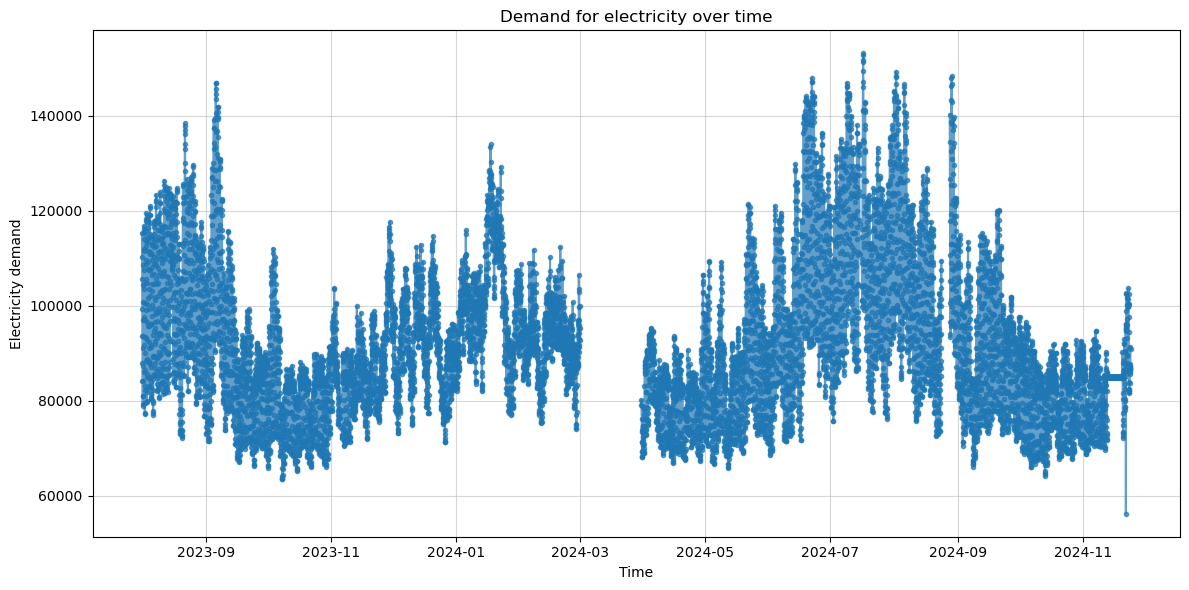

In [390]:
# Creating a 'demand' chart over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['period'], combined_df['demand'], marker='.', linestyle='-', alpha=0.7)
plt.title("Demand for electricity over time")
plt.xlabel("Time")
plt.ylabel("Electricity demand")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


#### For periods in which there is no data on electricity demand, but there is weather data, the data can be supplemented using machine learning models.

In [391]:
# Checking for missing rows in the 'demand' column
missing_demand = combined_df[combined_df['demand'].isna()]

# Checking if missing 'demand' has weather data available
available_weather_for_missing_demand = missing_demand.dropna(subset=[
    'temperature_c', 'dewpoint_c', 'wind_speed_kmh', 'relative_humidity', 'wind_direction', 'visibility_m'
])

print(f"Number of rows missing in 'demand': {len(missing_demand)}")
print(f"Number of missing rows in 'demand' that have weather data: {len(available_weather_for_missing_demand)}")


Number of rows missing in 'demand': 884
Number of missing rows in 'demand' that have weather data: 856


In [392]:
# Data preparation
weather_columns = ['temperature_c', 'dewpoint_c', 'wind_speed_kmh', 
                   'wind_direction', 'relative_humidity', 'visibility_m']
train_data = combined_df.dropna(subset=['demand'] + weather_columns)

X = train_data[weather_columns]
y = train_data['demand']

# Division into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definition of models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

# Models requiring standardization
scaled_models = ['Linear Regression', 'KNN']

# Fitting scaled data for these models
results = {}
for name in scaled_models:
    if name in models:
        model = models[name]
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = mae
        print(f"{name}: MAE = {mae:.2f}")

# Models without standardization
for name in models:
    if name not in scaled_models:
        model = models[name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = mae
        print(f"{name}: MAE = {mae:.2f}")



Linear Regression: MAE = 10505.60
KNN: MAE = 6414.84
Random Forest: MAE = 6329.91
XGBoost: MAE = 6567.55


#### The lowest MAE is for the Random Forest model. Let's adjust the hyperparameters.

In [393]:
# Parameters to GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Performing Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',  # Negative MAE for GridSearchCV compliance
    verbose=1
)

# Fitting the model to the data
grid_search.fit(X_train, y_train)

# The best model from Grid Search
best_model = grid_search.best_estimator_

# GridSearchCV Score Evaluation (MAE Negative to Positive)
best_cv_score = -grid_search.best_score_

# Prediction on test data
y_pred = best_model.predict(X_test)

# Model evaluation on test data
mae_best_model = mean_absolute_error(y_test, y_pred)

# Display the results
print("Best Random Forest parameters:", grid_search.best_params_)
print(f"MAE (GridSearchCV Validation Average): {best_cv_score:.2f}")
print(f"MAE on test data: {mae_best_model:.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
MAE (GridSearchCV Validation Average): 6494.04
MAE on test data: 6287.51


In [396]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             10661 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB


In [397]:
# Finding rows with missing 'demand'
missing_demand = combined_df[combined_df['demand'].isna()]

# Checking if weather data is available for missing 'demands'
weather_columns = ['temperature_c', 'dewpoint_c', 'wind_speed_kmh', 
                   'wind_direction', 'relative_humidity', 'visibility_m']
missing_demand_with_weather = missing_demand.dropna(subset=weather_columns)

# Preparing data for prediction
X_missing = missing_demand_with_weather[weather_columns]

# Prediction using the best model
predicted_demand = best_model.predict(X_missing)

# Filling the gaps in 'demand'
combined_df.loc[missing_demand_with_weather.index, 'demand'] = predicted_demand

# Display the results
print("The gaps in 'demand' have been filled.")


The gaps in 'demand' have been filled.


In [398]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             11517 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB


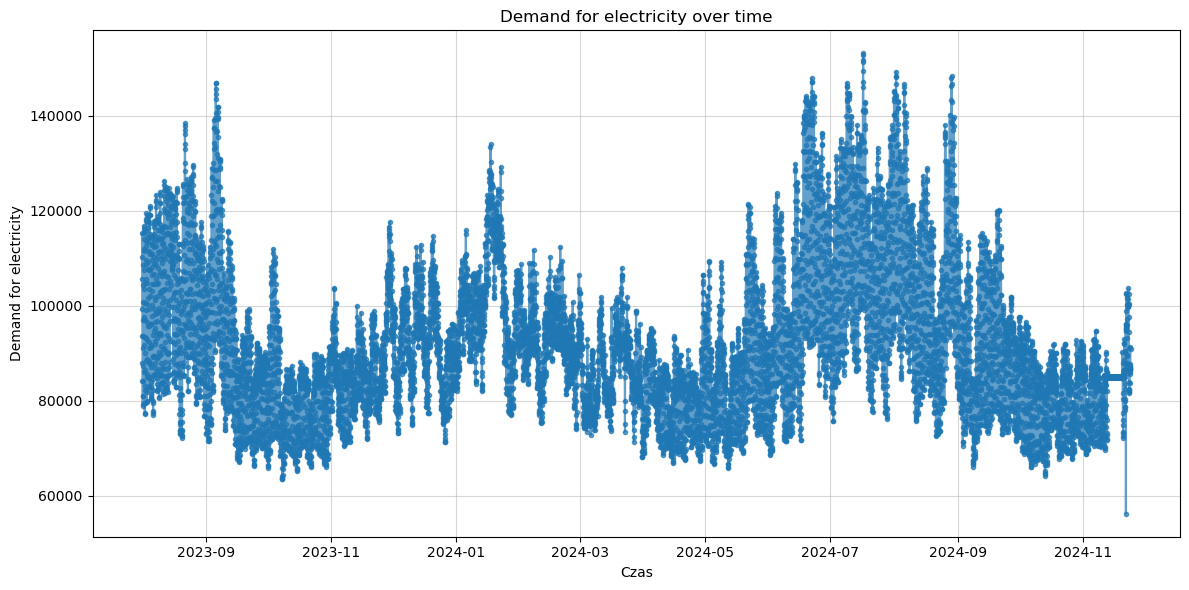

In [399]:
import matplotlib.pyplot as plt

# Creating a 'demand' chart over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['period'], combined_df['demand'], marker='.', linestyle='-', alpha=0.7)
plt.title("Demand for electricity over time")
plt.xlabel("Czas")
plt.ylabel("Demand for electricity")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


#### Not all missing data have been completed. Let's fill in the rest using the time window average method

In [296]:
# Adding auxiliary columns: time and day of the week
combined_df['hour'] = combined_df['period'].dt.hour
combined_df['day_of_week'] = combined_df['period'].dt.dayofweek



In [297]:
def fill_missing_with_past_means(df, window=14):
    filled_df = df.copy()
    for index, row in df[df['demand'].isna()].iterrows():
        hour = row['hour']
        day_of_week = row['day_of_week']
        
        # Setting a time slot (past only)
        window_start = row['period'] - pd.Timedelta(days=window)
        window_end = row['period']
        
        # Filtering data in a time window
        window_data = df[(df['period'] >= window_start) &
                         (df['period'] < window_end) &  # We only include previous data
                         (df['hour'] == hour) & 
                         (df['day_of_week'] == day_of_week)]['demand']
        
        # Average calculation and completion
        if not window_data.empty:
            filled_df.at[index, 'demand'] = window_data.mean()
    
    return filled_df


In [298]:
# Filling in gaps only based on past data
combined_df_filled = fill_missing_with_past_means(combined_df, window=14)

# Remove auxiliary columns
combined_df_filled = combined_df_filled.drop(columns=['hour', 'day_of_week'])

# Checking the number of missing items after completion
print("Number of missing items in 'demand' after completion:", combined_df_filled['demand'].isna().sum())


Number of missing items in 'demand' after completion: 0


In [299]:
combined_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             11545 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB


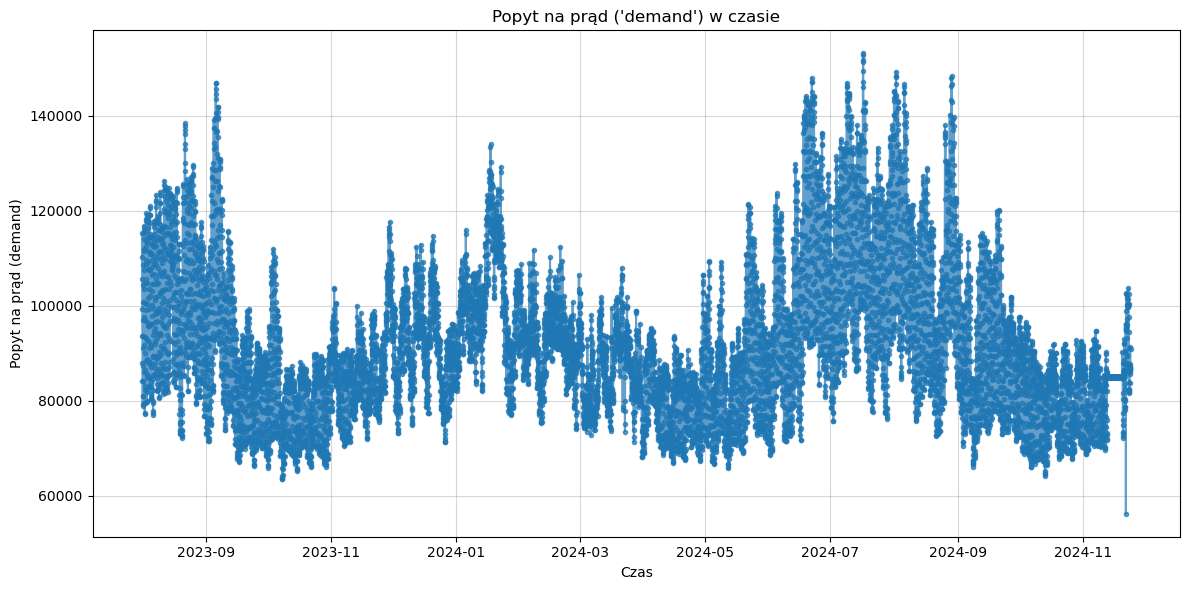

In [301]:
# Creating a 'demand' chart over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df_filled['period'], combined_df_filled['demand'], marker='.', linestyle='-', alpha=0.7)
plt.title("Popyt na prąd ('demand') w czasie")
plt.xlabel("Czas")
plt.ylabel("Popyt na prąd (demand)")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

#### At the end of the analyzed period, a constant demand can be observed. Let's try to change these constant values ​​to those calculated using the time window average method.

In [302]:
# Display data for the final time range
end_period = combined_df_filled[combined_df_filled['period'] >= '2024-11-01']
print(end_period[['period', 'demand']].tail(250))


                   period   demand
11295 2024-11-13 15:00:00  84962.0
11296 2024-11-13 16:00:00  84962.0
11297 2024-11-13 17:00:00  84962.0
11298 2024-11-13 18:00:00  84962.0
11299 2024-11-13 19:00:00  84962.0
...                   ...      ...
11540 2024-11-23 20:00:00  86632.0
11541 2024-11-23 21:00:00  85740.0
11542 2024-11-23 22:00:00  87825.0
11543 2024-11-23 23:00:00  91300.0
11544 2024-11-24 00:00:00  90957.0

[250 rows x 2 columns]


In [304]:
# Identification of the period with constant 'demand'
constant_demand_value = 84962.0
constant_demand_rows = combined_df_filled[combined_df_filled['demand'] == constant_demand_value]

# Display the date range with this problem
print("Fixed demand period:")
print(constant_demand_rows[['period', 'demand']].head())
print(constant_demand_rows[['period', 'demand']].tail())


Fixed demand period:
                   period   demand
11273 2024-11-12 17:00:00  84962.0
11274 2024-11-12 18:00:00  84962.0
11275 2024-11-12 19:00:00  84962.0
11276 2024-11-12 20:00:00  84962.0
11277 2024-11-12 21:00:00  84962.0
                   period   demand
11444 2024-11-19 20:00:00  84962.0
11445 2024-11-19 21:00:00  84962.0
11446 2024-11-19 22:00:00  84962.0
11447 2024-11-19 23:00:00  84962.0
11448 2024-11-20 00:00:00  84962.0


In [305]:
# Setting NaN for constant values ​​in the 'demand' column
combined_df_filled.loc[combined_df_filled['demand'] == constant_demand_value, 'demand'] = None

# Check the number of misses after removing constant values
print("Number of misses in 'demand' after removing constant values:", combined_df_filled['demand'].isna().sum())


Number of misses in 'demand' after removing constant values: 176


In [306]:
combined_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             11369 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB


In [307]:
# Adding auxiliary columns
combined_df_filled['hour'] = combined_df_filled['period'].dt.hour
combined_df_filled['day_of_week'] = combined_df_filled['period'].dt.dayofweek

# Filling gaps with time window averages
combined_df_filled = fill_missing_with_time_window_means(combined_df_filled, window=14)

# Remove auxiliary columns
combined_df_filled.drop(columns=['hour', 'day_of_week'], inplace=True)

# Checking the number of missing items after completion
print("Number of missing items in 'demand' after completion:", combined_df_filled['demand'].isna().sum())


Number of missing items in 'demand' after completion: 0


In [308]:
print("Number of lines in 'combined_df_filled':", len(combined_df_filled))
print("Number of missing items in 'demand':", combined_df_filled['demand'].isna().sum())


Number of lines in 'combined_df_filled': 11545
Number of missing items in 'demand': 0


In [309]:
combined_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   period             11545 non-null  datetime64[ns]
 1   demand             11545 non-null  float64       
 2   temperature_c      9789 non-null   float64       
 3   dewpoint_c         9790 non-null   float64       
 4   wind_speed_kmh     9788 non-null   float64       
 5   wind_direction     9788 non-null   float64       
 6   relative_humidity  9788 non-null   float64       
 7   visibility_m       9791 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 721.7 KB


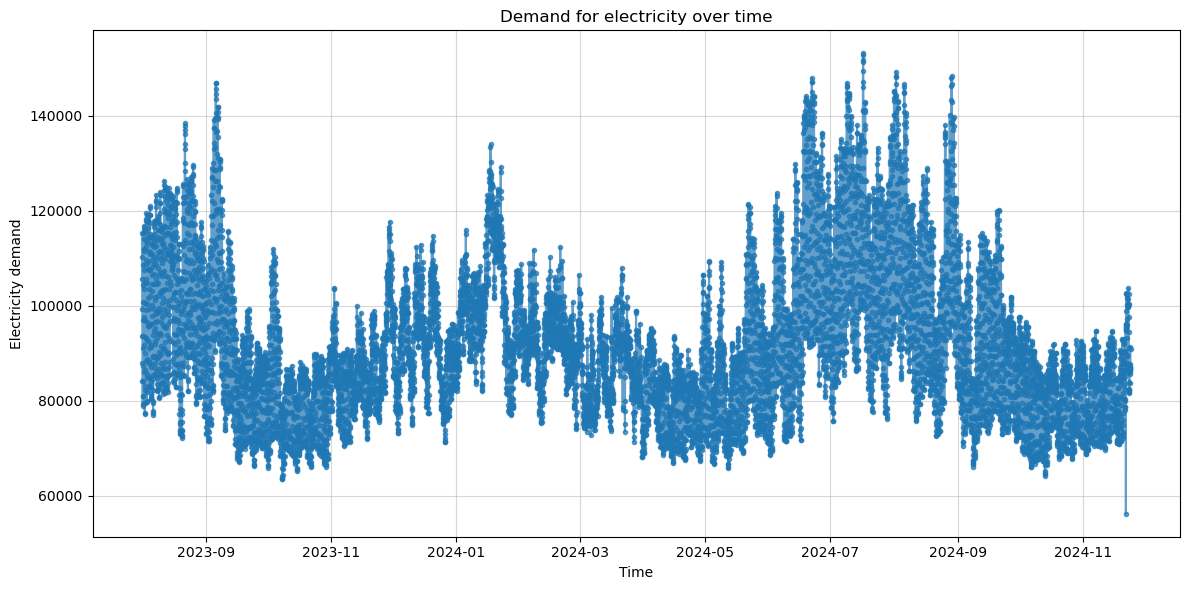

In [310]:
# Creating a 'demand' chart over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df_filled['period'], combined_df_filled['demand'], marker='.', linestyle='-', alpha=0.7)
plt.title("Demand for electricity over time")
plt.xlabel("Time")
plt.ylabel("Electricity demand")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Identification of trends and seasonality

#### The greatest demand for electricity is in the afternoon and at night

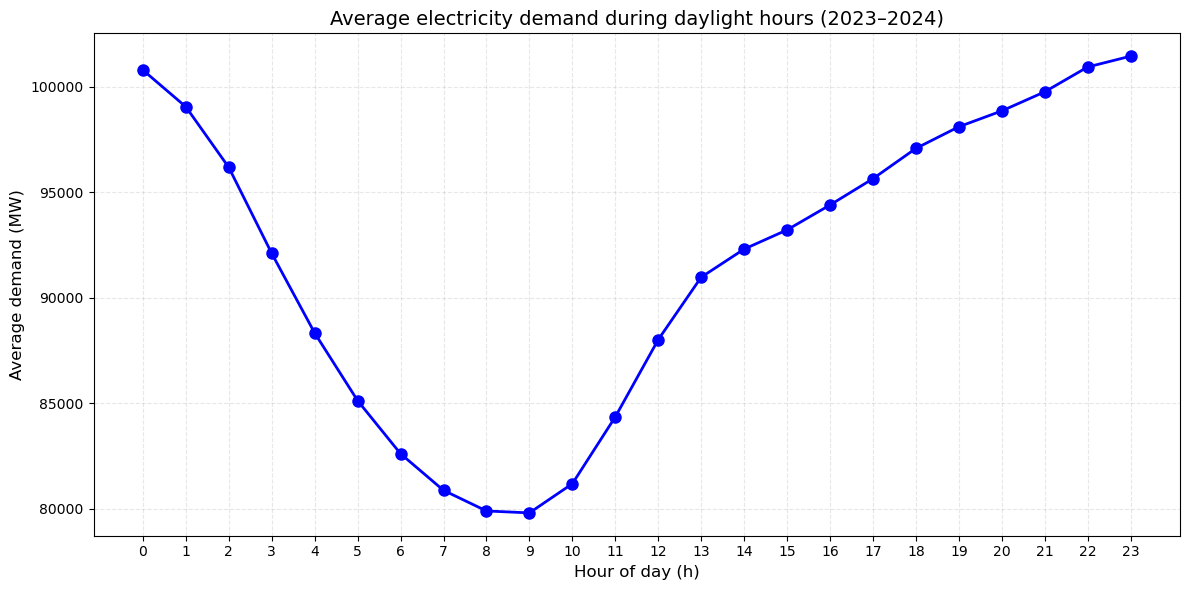

In [314]:
hourly_mean = combined_df_filled.groupby(combined_df_filled['period'].dt.hour)['demand'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_mean.index, hourly_mean, marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)
plt.title("Average electricity demand during daylight hours (2023–2024)", fontsize=14)
plt.xlabel("Hour of day (h)", fontsize=12)
plt.ylabel("Average demand (MW)", fontsize=12)
plt.xticks(range(0, 24), fontsize=10)  # Godziny od 0 do 23
plt.yticks(fontsize=10)  # Skala osi Y
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


#### On weekends, demand for electricity is lower than on other days of the week

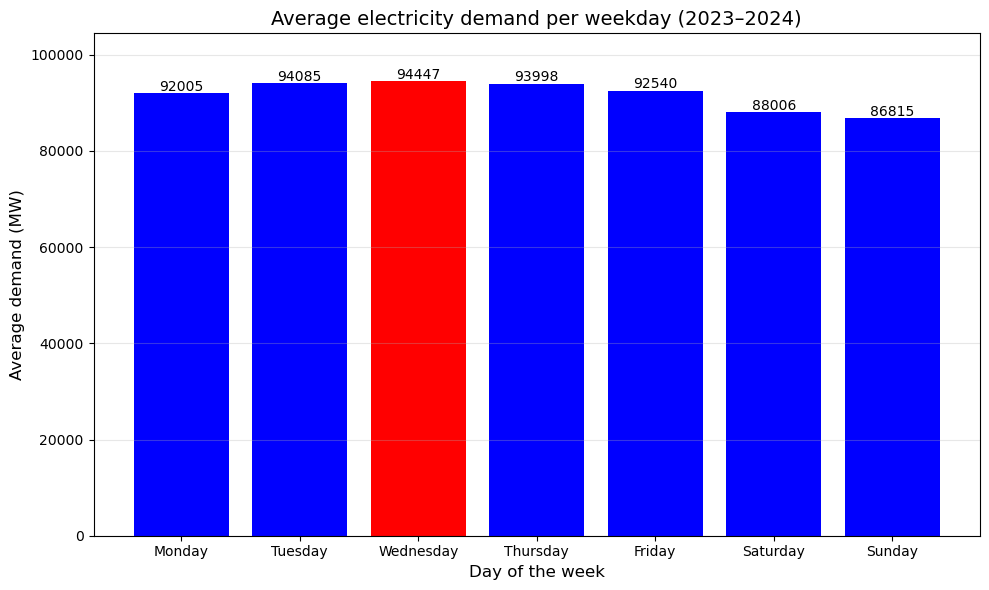

In [316]:
weekly_mean = combined_df_filled.groupby(combined_df_filled['period'].dt.dayofweek)['demand'].mean()

# Data
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
max_index = np.argmax(weekly_mean)
colors = ['blue' if i != max_index else 'red' for i in range(len(weekly_mean))]

# Chart
plt.figure(figsize=(10, 6))
bars = plt.bar(days, weekly_mean, color=colors)

# Adding values ​​to columns
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 500, f"{int(yval)}", ha='center', fontsize=10)

# Axis description and title
plt.title("Average electricity demand per weekday (2023–2024)", fontsize=14)
plt.xlabel("Day of the week", fontsize=12)
plt.ylabel("Average demand (MW)", fontsize=12)
plt.ylim(0, weekly_mean.max() + 10000)  
plt.grid(alpha=0.3, axis='y')  
plt.tight_layout()
plt.show()


#### The highest demand for electricity is in the summer months

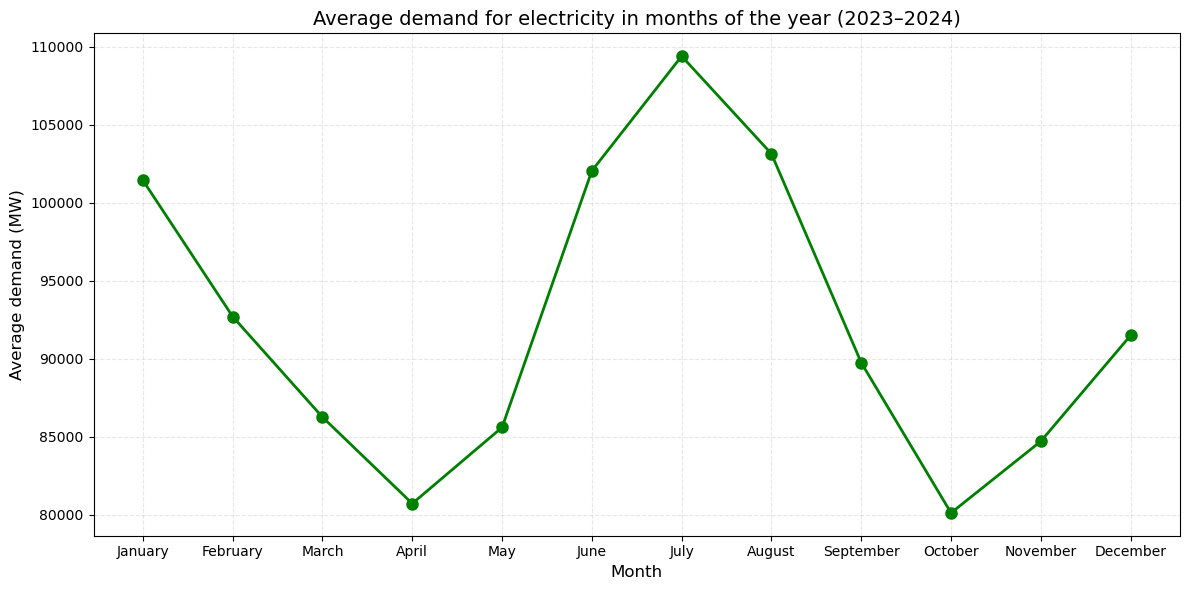

In [326]:
# List of month names in English
english_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                  'July', 'August', 'September', 'October', 'November', 'December']

# Calculation of average demand
monthly_mean = combined_df_filled.groupby(combined_df_filled['period'].dt.month)['demand'].mean()

# Chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', color='green', markersize=8, linewidth=2)

# Set month labels in English horizontally
plt.xticks(ticks=monthly_mean.index, labels=english_months, rotation=0, fontsize=10)

# Axis descriptions and title
plt.title("Average demand for electricity in months of the year (2023–2024)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average demand (MW)", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### Comparison of demand across seasons

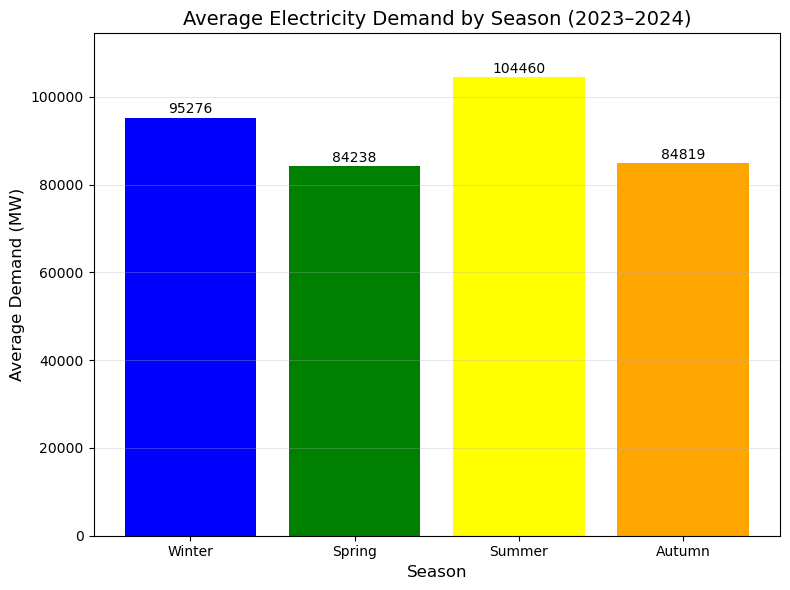

In [327]:
# Assigning a season to each date
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Adding a new column 'season' based on the month
combined_df_filled['season'] = combined_df_filled['period'].dt.month.apply(get_season)

# Calculating the average electricity demand for each season
seasonal_mean = combined_df_filled.groupby('season')['demand'].mean()

# Defining the order of seasons
seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_mean = seasonal_mean.reindex(seasons_order)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(seasonal_mean.index, seasonal_mean, color=['blue', 'green', 'yellow', 'orange'])

# Adding numeric values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, f"{int(yval)}", ha='center', fontsize=10)

# Axis labels and title
plt.title("Average Electricity Demand by Season (2023–2024)", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Demand (MW)", fontsize=12)
plt.ylim(0, seasonal_mean.max() + 10000)  # Extending the Y-axis range
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### Correlations

In [107]:
# Correlation between weather variables and demand
correlation = combined_df_filled[['temperature_c', 'dewpoint_c', 'wind_speed_kmh', 
                                  'relative_humidity', 'demand']].corr()
print(correlation['demand'])


temperature_c        0.485994
dewpoint_c           0.365898
wind_speed_kmh       0.098471
relative_humidity   -0.250566
demand               1.000000
Name: demand, dtype: float64


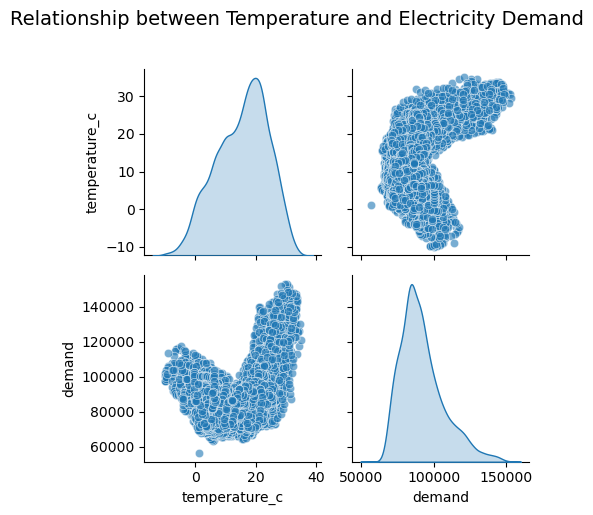

In [328]:
# Creating a pairplot for temperature and electricity demand
sns.pairplot(
    data=combined_df_filled,
    vars=['temperature_c', 'demand'],
    kind='scatter',
    diag_kind='kde',  # Distribution on the diagonal
    plot_kws={'alpha': 0.6}  # Setting point transparency
)

plt.suptitle("Relationship between Temperature and Electricity Demand", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


### Forecast using the Prophet model

In [335]:
# Splitting into training and test sets (80% - training, 20% - testing)
demand_data = combined_df_filled[['period', 'demand']]
train_data, test_data = train_test_split(demand_data, test_size=0.2, shuffle=False)

# Checking the results
print("Training data:", train_data.shape)
print("Test data:", test_data.shape)


Training data: (9236, 2)
Test data: (2309, 2)


07:16:07 - cmdstanpy - INFO - Chain [1] start processing
07:16:10 - cmdstanpy - INFO - Chain [1] done processing


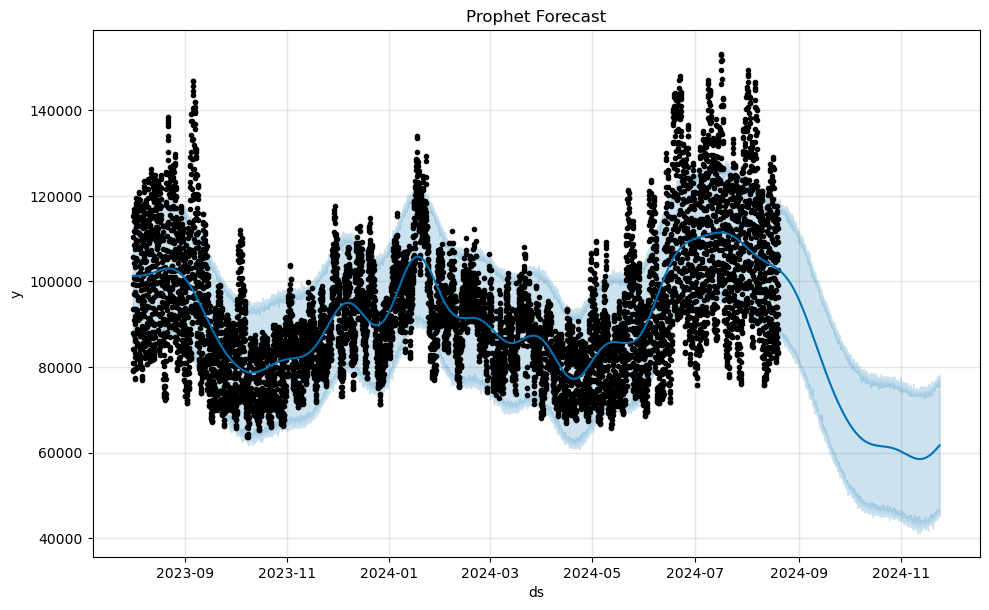

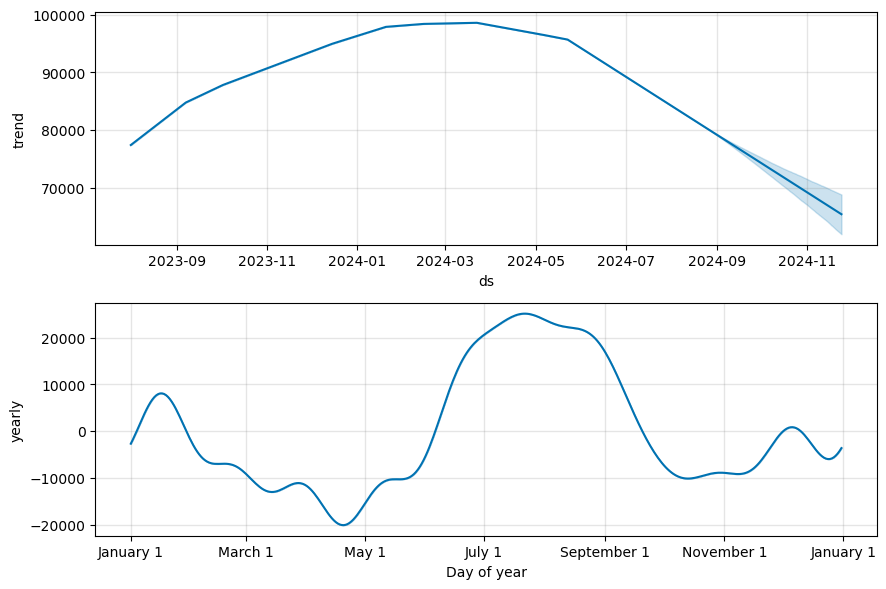

MAE Prophet: 17659.79


In [336]:
# Preparing data for Prophet
prophet_data = train_data[['period', 'demand']].rename(columns={'period': 'ds', 'demand': 'y'})

# Initializing the Prophet model
prophet_model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False,  
    seasonality_mode='additive'
)

# Fitting the model
prophet_model.fit(prophet_data)

# Creating future dates
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H')

# Forecasting
forecast = prophet_model.predict(future)

# Forecast plot
fig = prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Components plot (seasonality, trend, etc.)
fig2 = prophet_model.plot_components(forecast)
plt.show()

# Extracting the forecast for the test period
forecast_test = forecast[-len(test_data):]
test_data['Prophet_Predicted'] = forecast_test['yhat'].values

# Model evaluation on test data
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_data['demand'], test_data['Prophet_Predicted'])
print(f"MAE Prophet: {mae:.2f}")


07:34:19 - cmdstanpy - INFO - Chain [1] start processing
07:34:21 - cmdstanpy - INFO - Chain [1] done processing


MAE Prophet: 13592.65


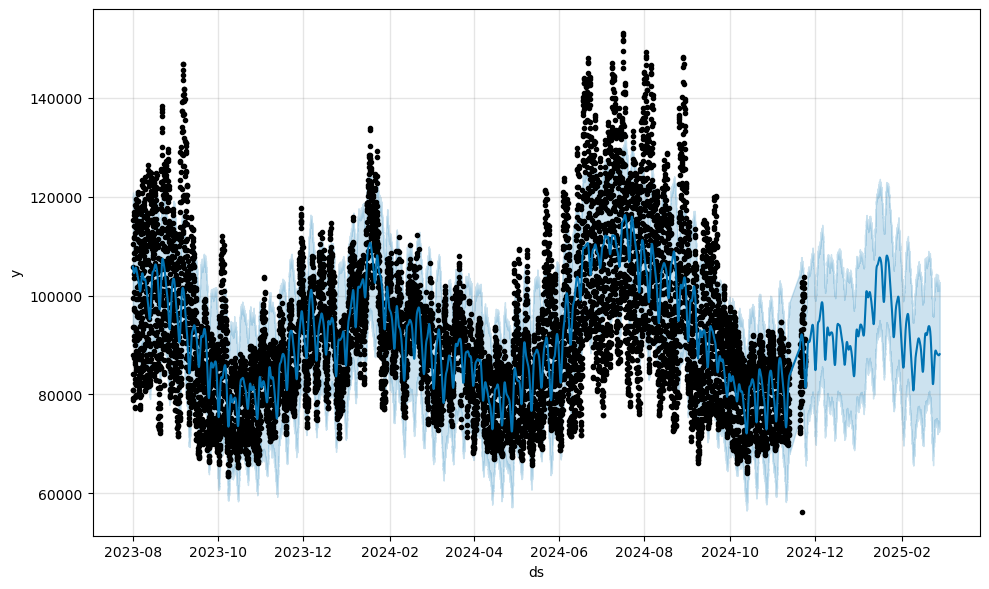

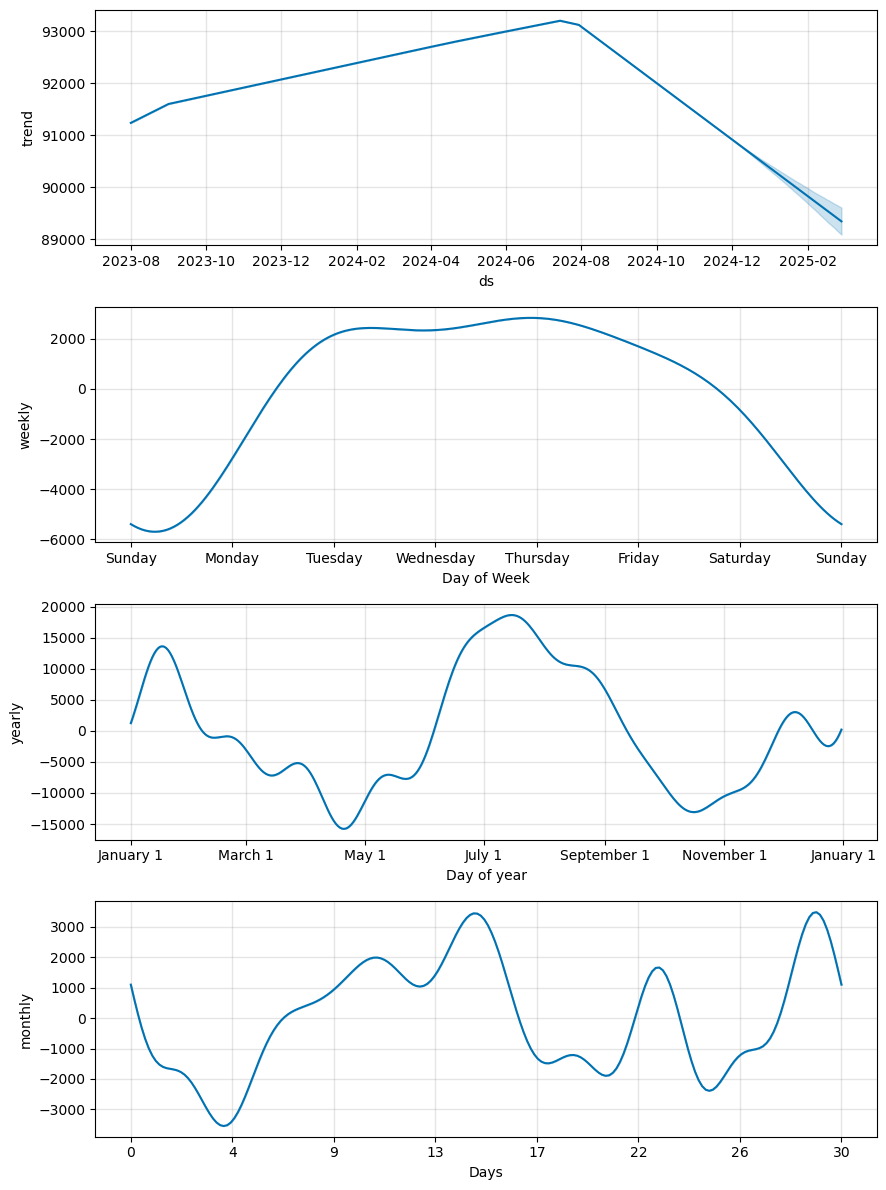

In [348]:
# Prophet model configuration without regressors
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# Adding custom monthly seasonality
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=10)

# Preparing input data
df_prophet = combined_df_cleaned[['period', 'demand']].rename(
    columns={'period': 'ds', 'demand': 'y'}
)

# Fitting the model
prophet.fit(df_prophet)

# Creating a dataframe for forecasting
future = prophet.make_future_dataframe(periods=2309, freq='H')

# Forecasting
forecast = prophet.predict(future)

# Forecast plot
fig = prophet.plot(forecast)
fig.show()

# Components plot (seasonalities and trends)
fig_components = prophet.plot_components(forecast)
fig_components.show()

# Calculating MAE
from sklearn.metrics import mean_absolute_error

# Comparing forecast with actual data
test_data = df_prophet[-2309:]  # Last data points as test set
forecast_test = forecast.iloc[-2309:]['yhat']

mae_prophet = mean_absolute_error(test_data['y'], forecast_test)
print(f"MAE Prophet: {mae_prophet:.2f}")


07:41:01 - cmdstanpy - INFO - Chain [1] start processing
07:41:04 - cmdstanpy - INFO - Chain [1] done processing


MAE Prophet with Hourly Seasonality: 13437.69


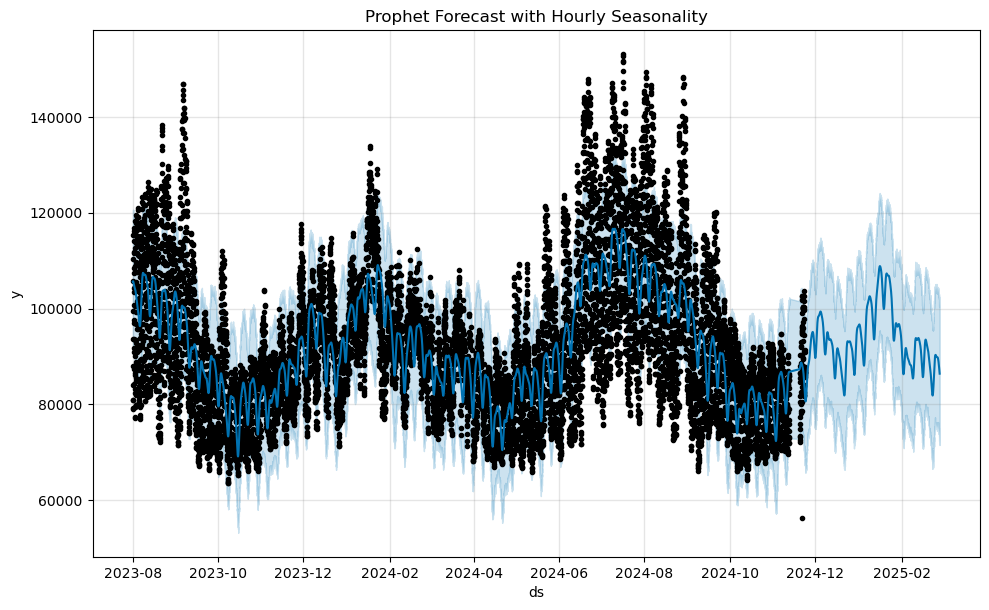

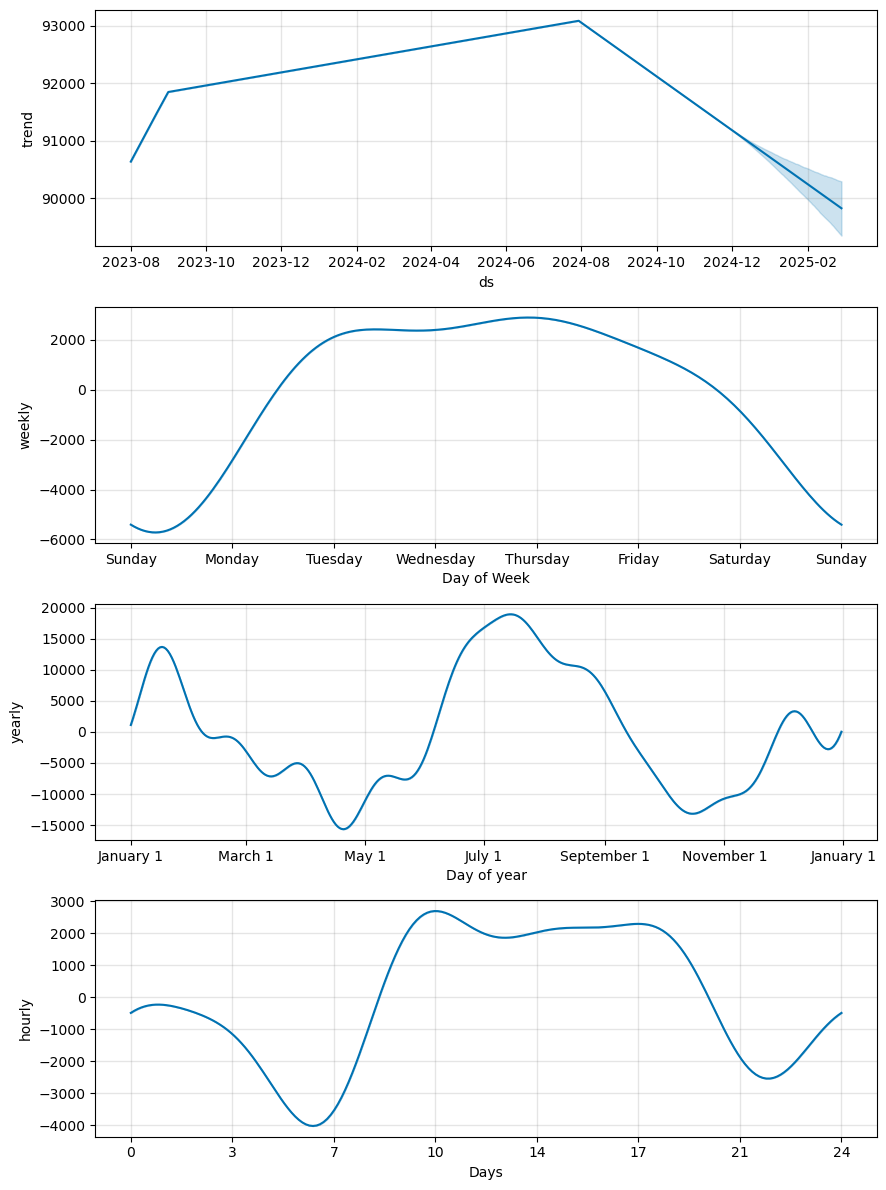

In [353]:
# Initializing the Prophet model
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Adding hourly seasonality
prophet.add_seasonality(name='hourly', period=24, fourier_order=5)

# Preparing the data
df_prophet = combined_df_cleaned[['period', 'demand']].rename(
    columns={'period': 'ds', 'demand': 'y'}
)

# Fitting the model
prophet.fit(df_prophet)

# Creating future dates
future = prophet.make_future_dataframe(periods=2309, freq='H')

# Forecasting
forecast = prophet.predict(future)

# Extracting forecast for the test period
forecast_test = forecast.iloc[-2309:]['yhat']

# Test data
test_data = df_prophet[-2309:]

# Calculating MAE
mae_prophet = mean_absolute_error(test_data['y'], forecast_test)
print(f"MAE Prophet with Hourly Seasonality: {mae_prophet:.2f}")

# Plotting the forecast
fig = prophet.plot(forecast)
plt.title("Prophet Forecast with Hourly Seasonality")
plt.show()

# Plotting components, including the hourly seasonality
fig_components = prophet.plot_components(forecast)
plt.show()


#### After testing different combinations of parameters, a model was created that achieved the lowest MAE

13:09:38 - cmdstanpy - INFO - Chain [1] start processing
13:09:42 - cmdstanpy - INFO - Chain [1] done processing
13:09:46 - cmdstanpy - INFO - Chain [1] start processing
13:09:53 - cmdstanpy - INFO - Chain [1] done processing
13:09:59 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:09 - cmdstanpy - INFO - Chain [1] start processing
13:10:24 - cmdstanpy - INFO - Chain [1] done processing
13:10:29 - cmdstanpy - INFO - Chain [1] start processing
13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing
13:10:56 - cmdstanpy - INFO - Chain [1] done processing
13:10:59 - cmdstanpy - INFO - Chain [1] start processing
13:11:03 - cmdstanpy - INFO - Chain [1] done processing
13:11:06 - cmdstanpy - INFO - Chain [1] start processing
13:11:09 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:16 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'fourier_order_hourly': 5, 'MAE': 12858.20318179036}


13:16:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing


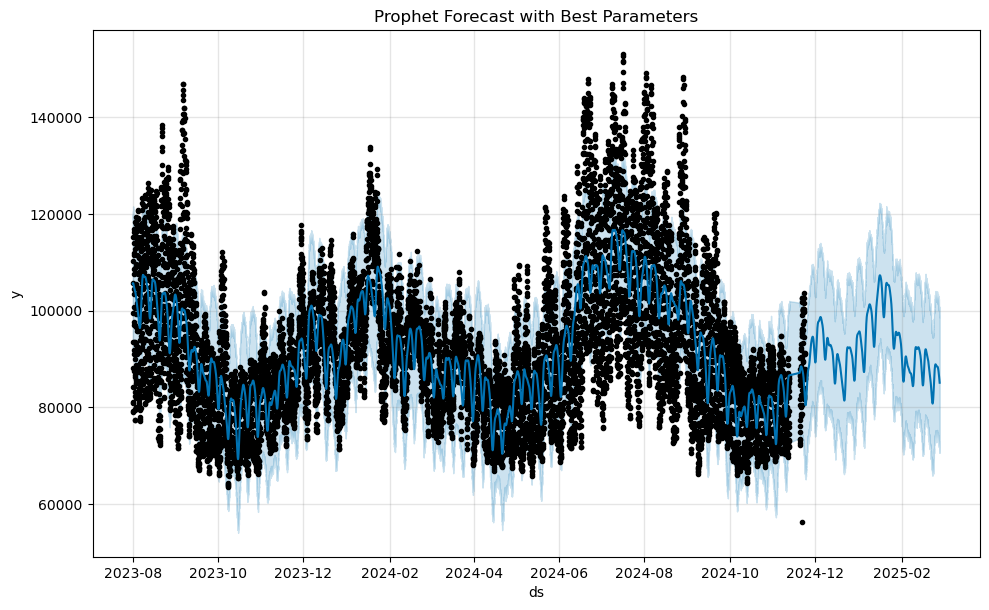

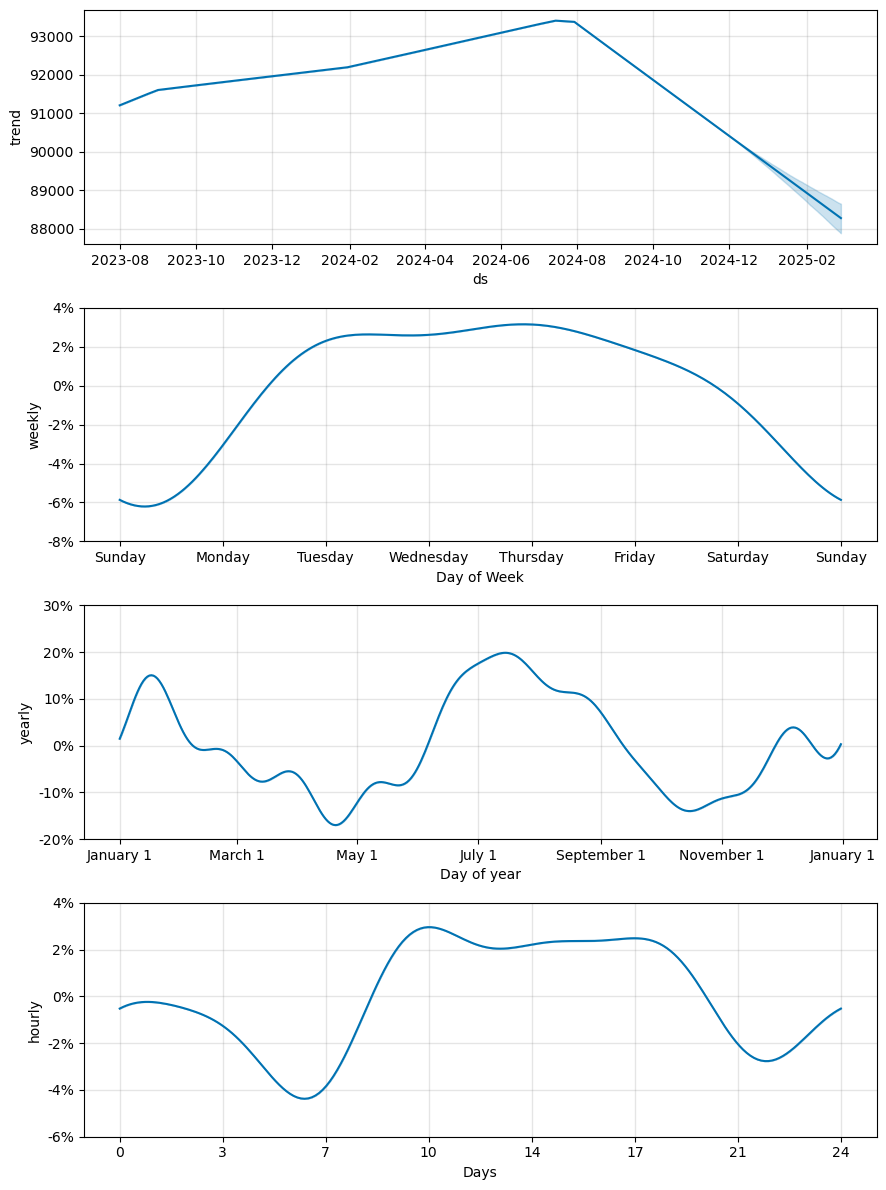

In [357]:
# List of parameters to test
param_grid = {
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order_hourly': [3, 5, 7]  # Fourier orders for hourly seasonality
}

# List to store results
results = []

# Loop through parameter combinations
for yearly in param_grid['yearly_seasonality']:
    for weekly in param_grid['weekly_seasonality']:
        for daily in param_grid['daily_seasonality']:
            for mode in param_grid['seasonality_mode']:
                for fourier_hourly in param_grid['fourier_order_hourly']:
                    
                    # Initialize Prophet model
                    prophet = Prophet(
                        yearly_seasonality=yearly,
                        weekly_seasonality=weekly,
                        daily_seasonality=daily,
                        seasonality_mode=mode
                    )
                    
                    # Add custom hourly seasonality
                    prophet.add_seasonality(name='hourly', period=24, fourier_order=fourier_hourly)
                    
                    # Fit the model
                    prophet.fit(df_prophet)
                    
                    # Forecast
                    future = prophet.make_future_dataframe(periods=2309, freq='H')
                    forecast = prophet.predict(future)
                    
                    # Calculate MAE
                    forecast_test = forecast.iloc[-2309:]['yhat']
                    test_data = df_prophet[-2309:]
                    mae = mean_absolute_error(test_data['y'], forecast_test)
                    
                    # Save results
                    results.append({
                        'yearly_seasonality': yearly,
                        'weekly_seasonality': weekly,
                        'daily_seasonality': daily,
                        'seasonality_mode': mode,
                        'fourier_order_hourly': fourier_hourly,
                        'MAE': mae
                    })

# Sort results by MAE
results = sorted(results, key=lambda x: x['MAE'])

# Display the best configuration
best_params = results[0]
print("Best Parameters:", best_params)

# Fit the best model for visualization
prophet = Prophet(
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality'],
    seasonality_mode=best_params['seasonality_mode']
)
prophet.add_seasonality(name='hourly', period=24, fourier_order=best_params['fourier_order_hourly'])
prophet.fit(df_prophet)

# Forecast with the best parameters
future = prophet.make_future_dataframe(periods=2309, freq='H')
forecast = prophet.predict(future)

# Plotting the forecast
fig = prophet.plot(forecast)
plt.title("Prophet Forecast with Best Parameters")
plt.show()

# Plotting components
fig_components = prophet.plot_components(forecast)
plt.show()


## Conclusions

The objective of this project was to analyze and forecast electricity demand using historical data combined with weather variables. A significant focus was placed on understanding the patterns and dependencies within the data while addressing challenges such as missing values, irregular timestamps, and limited future weather information. By leveraging advanced time series modeling, the project aimed to provide accurate and interpretable forecasts that capture seasonal and long-term trends.

The dataset consisted of hourly electricity demand spanning over a year (08-2023 to 11-2024) and included weather variables such as temperature, dew point, wind speed, humidity, and visibility. However, the data posed several challenges: substantial missing values, particularly in weather variables, irregularities in timestamps, and anomalous flat demand periods. These issues required careful preprocessing, including using machine learning techniques to predict missing demand values, time-window-based averages for smaller gaps, and replacing flat demand values with modeled estimates.

Through exploratory data analysis, the project revealed strong seasonal patterns in electricity demand. Daily, weekly, monthly, and yearly trends were identified, with demand peaking at specific hours of the day and during particular months of the year. Correlation analysis further highlighted the significant influence of temperature on electricity consumption, indicating that weather variables play a critical role in demand forecasting.

Among the various models considered, the Prophet model emerged as the most suitable for this project. Its ability to handle complex seasonalities, missing data, and custom periodic trends made it a robust choice. Prophet was fine-tuned using a grid search approach, incorporating yearly, weekly, daily, and hourly seasonality. The best configuration achieved a Mean Absolute Error (MAE) of 12,858 MW, indicating a high level of accuracy. Visualizations of the forecast and seasonal components demonstrated that the model effectively captured the intricate patterns in the data.

In conclusion, this project successfully forecasted electricity demand by addressing data irregularities, leveraging detailed seasonality analysis, and fine-tuning the Prophet model. The insights gained from this analysis underscore the utility of time series models in understanding and predicting electricity consumption patterns.






